In [39]:
import pandas as pd
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import glob
from datetime import datetime, timedelta



In [40]:

# Get all CSV files matching the pattern
csv_files = glob.glob('../../../data/Apartments/listings_data_m2_medellin*.csv')

# Read and concatenate all CSV files into a single DataFrame
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

In [41]:

# Get today's date and the previous month
today = datetime.today()
first_day_this_month = today.replace(day=1)
last_day_prev_month = first_day_this_month - timedelta(days=1)
prev_month = last_day_prev_month.month
prev_year = last_day_prev_month.year

# Convert 'Extraction Date' to datetime if not already
df['Extraction Date'] = pd.to_datetime(df['Extraction Date'])

# Filter rows where 'Extraction Date' is in the previous month
# df = df[(df['Extraction Date'].dt.month == prev_month) & (df['Extraction Date'].dt.year == prev_year)]

df.drop_duplicates(subset='propertyId', inplace=True)

In [42]:

# Extract longitude and latitude from the 'coordinates' column
df['coordinates'] = df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['lon'] = df['coordinates'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)
df['lat'] = df['coordinates'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)

# Drop rows with missing coordinates
df = df[(df['lon'] != 0.0) & (df['lat'] != 0.0)]
df_map = df.dropna(subset=['lon', 'lat'])



In [43]:
# Load the shapefile
gdf = gpd.read_file('shp_comunas_y_corregimientos_/comunas_y_corregimientos_.shp')
gdf = gdf.drop(columns=['fecha_actu'])
gdf = gdf[~gdf['nombre'].isin([
    'Corregimiento de San Sebastián de Palmitas',
    'Corregimiento de San Cristóbal',
    'Corregimiento de Altavista',
    'Corregimiento de Santa Elena',
    'Corregimiento de San Antonio de Prado',
    'None'
])]

gdf = gdf[gdf['nombre'].notna()]

In [44]:

# Ensure gdf is in the same CRS as the coordinates (EPSG:4326)
gdf_4326 = gdf.to_crs(epsg=4326)

# Create geometry column in df_map
df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert df_map to GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_map, geometry='geometry', crs='EPSG:4326')

# Spatial join to get neighbourhood names
gdf_points = gpd.sjoin(gdf_points, gdf_4326[['nombre', 'geometry']], how='left', predicate='within')

# Add the neighbourhood name from gdf as a new column
df_map['neighbourhood_from_shape'] = gdf_points['nombre']

/tmp/ipykernel_48565/1551281998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
/tmp/ipykernel_48565/1551281998.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map['neighbourhood_from_shape'] = gdf_points['nombre']


In [45]:
# Calculate average salePrice for each neighbourhood in df_map
avg_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].mean()
# Calculate the number of properties per neighbourhood
count_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].count()
gdf_4326['num_properties'] = gdf_4326['nombre'].map(count_by_neigh).fillna(0).astype(int)

# Map the average price to the gdf_4326 GeoDataFrame based on 'nombre'
gdf_4326['avg_price'] = gdf_4326['nombre'].map(avg_price_by_neigh)

gdf_4326['avg_price'] = gdf_4326['avg_price'].fillna(0)

gdf_4326

,codigo,nombre,identifica,limitemuni,subtipo_co,Shape_Leng,Shape_Area,geometry,num_properties,avg_price
0,01,Popular,Comuna 1,001,1,9604.447484,3.097941e+06,"POLYGON ((-75.54803 6.30436, -75.54795 6.30431...",0,0.000000e+00
1,02,Santa Cruz,Comuna 2,001,1,8597.293652,2.195663e+06,"POLYGON ((-75.55703 6.31007, -75.55699 6.31003...",0,0.000000e+00
2,03,Manrique,Comuna 3,001,1,12077.558708,5.096182e+06,"POLYGON ((-75.54252 6.28632, -75.54252 6.28632...",0,0.000000e+00
3,04,Aranjuez,Comuna 4,001,1,9642.676522,4.883314e+06,"POLYGON ((-75.56229 6.29126, -75.56221 6.29125...",1,3.550000e+08
4,05,Castilla,Comuna 5,001,1,16098.031666,6.063916e+06,"POLYGON ((-75.56566 6.31261, -75.56559 6.31259...",0,0.000000e+00
5,06,Doce de Octubre,Comuna 6,001,1,10709.846514,3.849812e+06,"POLYGON ((-75.57586 6.31093, -75.57584 6.31092...",0,0.000000e+00
6,07,Robledo,Comuna 7,001,1,23265.232357,9.462008e+06,"POLYGON ((-75.5905 6.29592, -75.59049 6.2959, ...",2,2.115000e+08
7,08,Villa Hermosa,Comuna 8,001,1,16392.858637,5.716968e+06,"POLYGON ((-75.55077 6.26237, -75.55071 6.26237...",3,3.783333e+08
8,09,Buenos Aires,Comuna 9,001,1,18364.901234,6.052668e+06,"POLYGON ((-75.55502 6.24505, -75.55501 6.24504...",18,5.151833e+08
9,10,La Candelaria,Comuna 10,001,1,13632.701742,7.360811e+06,"POLYGON ((-75.56426 6.26394, -75.56412 6.26393...",30,3.952500e+08


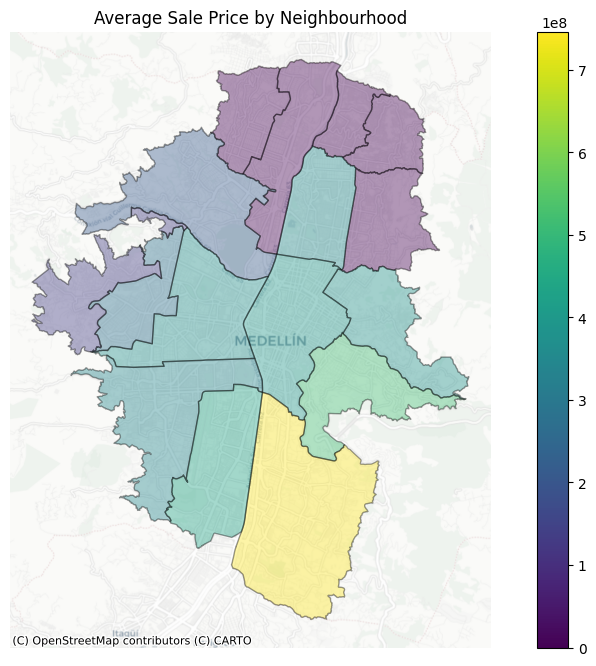

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_4326.plot(column='avg_price', ax=ax, legend=True, cmap='viridis', edgecolor='k', alpha=0.4)
ctx.add_basemap(ax, crs=gdf_4326.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.title('Average Sale Price by Neighbourhood')
plt.axis('off')
plt.show()